In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

import logging
from dataclasses import asdict
from typing import *
import numpy as np
import numpy.typing as npt
import torch
import torch.nn as nn
from ndp.signal import Signal
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from tqdm import trange  # type: ignore
from library.config_schema import MainConfig, ParamsDict, flatten_dict, get_selected_params
from library.func_utils import infinite, limited
from library.interpreter import ModelInterpreter
from library.models import SimpleNet
from library.runner import LossFunction, TestIter, TrainIter, eval_model, train_model
from library.visualize import get_model_weights_figure
import torch.nn as nn
from library.models import SimpleNet
from library.config_schema import *
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from mne.datasets import multimodal
from __future__ import annotations

import logging
import operator as op
from dataclasses import asdict, dataclass
from functools import total_ordering
from typing import Callable, Generator, Iterable, Protocol

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from library.type_aliases import ChanBatch
from sklearn.metrics import accuracy_score
from library.metrics import Metrics
from sklearn.preprocessing import StandardScaler


from torch.utils.data import Dataset

# Dataset = namedtuple('Dataset', 'X Y')
Loaders = dict[str, DataLoader]
log = logging.getLogger(__name__)
fh = logging.FileHandler('../Source/simplenet-history.log')
fh.setLevel(logging.DEBUG)
log.addHandler(fh)

In [2]:
def prepare_data(epochs_list: list[mne.Epochs]):
    X = np.array([])
    Y = list()
    scaler = StandardScaler()
    for i, epochs in enumerate(epochs_list):
        epochs = epochs.load_data().pick_types(meg='grad')
        data = np.array([scaler.fit_transform(epoch) for epoch in epochs.get_data()])

        if i == 0:
            X = data.copy()
        else:
            X = np.append(X, data, axis=0)

        Y += [i for _ in range(data.shape[0])]

    Y = np.array(Y)

    return X, Y


def create_data_loaders(
    X: Signal[npt._32Bit],
    Y: Signal[npt._32Bit],
    batch_size: Optional[int] = 100
):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
    train, test = Discrete(X_train, Y_train), Discrete(X_test, Y_test)

    train=DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
    test=DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)

    return dict(
        train=train,
        test=test
    )


def simple_accuracy_score(
    y_true: Union[list[int], np.ndarray],
    y_pred: Union[list[int], np.ndarray]
) -> float:
    assert len(y_true) == len(y_pred), f"{len(y_true) = } but {len(y_pred) = }"
    correct = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:
            correct += 1
    return correct / len(y_true)


@total_ordering
@dataclass
class ClassificationMetrics(Metrics):
    acc: float
    loss: float

    @classmethod
    def calc(cls, y_predicted: ChanBatch, y_true: ChanBatch, loss: float) -> ClassificationMetrics:
        acc = simple_accuracy_score(one_hot_decoder(y_true), one_hot_decoder(y_predicted))
        return cls(acc, loss)

    def __lt__(self, other: ClassificationMetrics) -> bool:
        return (self.acc, -self.loss) < (other.acc, -other.loss)


def get_metrics(model: nn.Module, loss: LossFunction, ldrs: Loaders, n_iter: int) -> ParamsDict:
    metrics = {}
    for stage, ldr in ldrs.items():
        tr = trange(n_iter, desc=f"Evaluating model on {stage}")
        eval_iter = limited(TestIter(model, ldr, loss)).by(tr)
        metrics[stage] = asdict(eval_model(eval_iter, ClassificationMetrics, n_iter))

    log.debug(f"{metrics=}")
    return flatten_dict(metrics, sep="/")


def one_hot_encoder(Y: np.ndarray) -> np.ndarray:
    y = list()
    n_classes = len(np.unique(Y))

    for val in Y:
        new_y_value = np.zeros(n_classes)
        new_y_value[val] = 1
        y.append(new_y_value)

    return np.array(y)


def one_hot_decoder(y: np.array) -> np.array:
    y_decoded = list()
    for val in y:
        y_decoded.append(np.where(val == val.max())[0][0])

    return np.array(y_decoded)


@dataclass
class Discrete(Dataset):

    X: np.ndarray # array of shape (n_samples, n_sensors)
    Y: np.ndarray # array of shape (n_samples, n_classes)

    def __post_init__(self) -> None:
        assert self.X.dtype == np.float32, f'wrong features type: {self.X.dtype} (must be np.float32)'
        assert len(self.X) == len(self.Y), f'features and target have different sizes: {self.X.shape = }, {self.Y.shape = }'

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, i: int) -> tuple[np.ndarray, int]:
        X = self.X[i].T
        Y = self.Y[i]
        return X, Y

In [8]:
mne.set_log_level(verbose='CRITICAL')
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)
cond = raw.acqparser.get_condition(raw, None)
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
model_upd_freq = 250
n_steps = 20000
lr=0.0003
metric_iter=250


featuresextcfg = FeatureExtractorConfig(
    in_channels=204,
    downsampling=102, # half of input
    hidden_channels=32, # as in LFCNN
    filtering_size=15, # band-pass filter -> as in the 2nd layer of LFCNN
    envelope_size=15 # low-pass filter, same as band-pass
)

modelcfg = SimpleNetConfig(
    out_channels = 8,
    lag_backward=60, # -100ms with 600 Hz -> 0.1*600 = 60 samples
    lag_forward=300, # 500ms with 600 Hz -> .5*600 = 300 samples
    use_lstm=False,
    feature_extractor=featuresextcfg
)

maincfg = MainConfig(
    debug=False,
    lag_backward=60,
    lag_forward=300,
    target_features_cnt=1,
    selected_channels=[int(channel) for channel in epochs_list[0]._channel_type_idx['grad']],
    model=modelcfg,
    dataset=None,
    batch_size=100,
    n_steps=n_steps,
    metric_iter=metric_iter,
    model_upd_freq=model_upd_freq,
    train_test_ratio=.7,
    learning_rate=lr,
    subject='test-subject',
    plot_loaded=False
)

In [4]:
X, Y = prepare_data(epochs_list)
X = np.transpose(X, (0, 2, 1))
X.shape

(940, 361, 204)

In [5]:
from library.type_aliases import ChanBatchTensor, SigBatchTensor
from library.models import FeatureExtractor
from scipy.signal import firwin

class FeatureExtractorFrozenEnvelopes(FeatureExtractor):
    def __init__(self,
            cfg: FeatureExtractorConfig,
            sfreq: int,
            lfreq: int
        ):
        self.filter_weights = firwin(cfg.filtering_size, lfreq, pass_zero='lowpass', nyq=sfreq//2)
        super().__init__(cfg)


    def _create_envelope_detector(self, nch: int) -> nn.Sequential:
        kern_conv, kern_env = self.cfg.filtering_size, self.cfg.envelope_size
        pad_conv, pad_env = int(self.cfg.filtering_size / 2), int(self.cfg.envelope_size / 2)
        model = nn.Sequential(
            nn.Conv1d(nch, nch, kernel_size=kern_conv, bias=False, groups=nch, padding=pad_conv),
            nn.BatchNorm1d(nch, affine=False),
            nn.LeakyReLU(-1),  # just absolute value
            nn.Conv1d(nch, nch, kernel_size=kern_env, groups=nch, padding=pad_env),
        )

        with torch.no_grad():
            model[-1].weights = nn.Parameter(
                torch.from_numpy(np.array([
                    np.expand_dims(self.filter_weights, 0)
                    for _ in range(self.cfg.hidden_channels)
                ]))
            )
        model[-1].requires_grad_(False)

        return model


class SimpleNet(nn.Module):
    def __init__(
        self,
        cfg: SimpleNetConfig,
        feature_extractor: Optional[FeatureExtractor] = None
    ):
        super(self.__class__, self).__init__()
        self.is_use_lstm = cfg.use_lstm
        ext_cfg = cfg.feature_extractor
        self.feature_extractor = FeatureExtractor(ext_cfg) if feature_extractor is None else feature_extractor

        window_size = cfg.lag_backward + cfg.lag_forward + 1
        final_out_features = (window_size // ext_cfg.downsampling + 1) * ext_cfg.hidden_channels

        assert window_size > ext_cfg.filtering_size
        assert window_size > ext_cfg.envelope_size

        self.features_batchnorm = nn.BatchNorm1d(final_out_features, affine=False)
        if cfg.use_lstm:
            assert ext_cfg.hidden_channels % 2 == 0, "hidden channels number must be even"
            hc = ext_cfg.hidden_channels
            self.lstm = nn.LSTM(hc, hc // 2, num_layers=1, batch_first=True, bidirectional=True)

        self.fc_layer = nn.Linear(final_out_features, cfg.out_channels)

    def forward(self, x: SigBatchTensor) -> ChanBatchTensor:
        features = self.feature_extractor(x)
        if self.is_use_lstm:
            features = self.lstm(features.transpose(1, 2))[0].transpose(1, 2)
        features = features.reshape((features.shape[0], -1))
        self.features_scaled = self.features_batchnorm(features)
        output = self.fc_layer(self.features_scaled)
        return output

In [9]:

ldrs = create_data_loaders(X.astype(np.float32), one_hot_encoder(Y).astype(np.float32), 100)
ildrs = dict(
    train=infinite(ldrs['train']),
    test=infinite(ldrs['test'])
)
model = SimpleNet(
    modelcfg,
    FeatureExtractorFrozenEnvelopes(
        modelcfg.feature_extractor, 600, 5
    )
)
# loss = nn.MSELoss()
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_iter = map(
    lambda x: ClassificationMetrics.calc(*x), infinite(TrainIter(model, ldrs["train"], loss, optimizer))
)
test_iter = map(lambda x: ClassificationMetrics.calc(*x), infinite(TestIter(model, ldrs["test"], loss)))

tr = trange(n_steps, desc="Experiment main loop")
with SummaryWriter("TB") as sw:
    train_model(train_iter, test_iter, tr, model, model_upd_freq, sw)
    metrics = get_metrics(model, loss, ildrs, metric_iter)
    log.info("Final metrics: " + ", ".join(f"{k}={v}" for k, v in metrics.items()))
    print("Final metrics: " + ", ".join(f"{k}={v}" for k, v in metrics.items()))
    options = {"debug": [True, False]}
    hparams = get_selected_params(OmegaConf.create(maincfg.__dict__))
    sw.add_hparams(hparams, metrics, hparam_domain_discrete=options, run_name="hparams")
    n_branches = maincfg.model.feature_extractor.hidden_channels
    signal = Signal(np.reshape(X, (X.shape[0]*X.shape[1], X.shape[2])), 600, [])
    mi = ModelInterpreter(model.feature_extractor, signal)
    fig = get_model_weights_figure(mi, epochs_list[0].info, n_branches)
    sw.add_figure(tag=f"nsteps = {maincfg.n_steps}", figure=fig)

Evaluating model on test: 100%|██████████| 250/250 [00:07<00:00, 35.70it/s]


Final metrics: train/acc=1.0, train/loss=0.0006967047366779297, test/acc=0.20947999999999997, test/loss=3.079737916946411


In [11]:
from library.visualize import MneInfoWithLayout, InterpretPlotLayout, plot_temporal_as_line
import matplotlib.figure as mpl_fig
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp

class GradTopoVisualizer:
    def __init__(self, info: MneInfoWithLayout):
        self.info = info

    def __call__(self, ax, t, style: str | None = None) -> None:
        tt = skp.minmax_scale(np.abs(t))

        if len(tt) == 306:
            meg_idx = mne.pick_types(self.info, meg="mag")  # pyright: ignore
            info = mne.pick_info(self.info, sel=meg_idx)
            tt = (tt[::3] + tt[1::3] + tt[2::3]) / 3
            mne.viz.plot_topomap(tt, info, axes=ax, show=False)
        elif len(tt) == 204:
            meg_idx = mne.pick_types(self.info, meg="grad")  # pyright: ignore
            info = mne.pick_info(self.info, sel=meg_idx)
            mne.viz.plot_topomap(tt, info, axes=ax, show=False)
        elif len(tt) == 102:
            meg_idx = mne.pick_types(self.info, meg="mag")  # pyright: ignore
            info = mne.pick_info(self.info, sel=meg_idx)
            mne.viz.plot_topomap(tt, info, axes=ax, show=False)


def get_model_weights_figure(mi: ModelInterpreter, info: MneInfoWithLayout, n: int) -> mpl_fig.Figure:
    freqs, weights, patterns = mi.get_temporal(nperseg=1000)
    sp = mi.get_spatial_patterns()
    sp_naive = mi.get_naive()
    plot_topo = GradTopoVisualizer(info)
    pp = InterpretPlotLayout(n, plot_topo, plot_temporal_as_line)

    pp.FREQ_XLIM = 150
    pp.add_temporal(freqs, weights, "weights")
    pp.add_temporal(freqs, patterns, "patterns")
    pp.add_spatial(sp, "patterns")
    pp.add_spatial(sp_naive, "naive")
    pp.finalize()
    plt.switch_backend("agg")
    return pp.fig

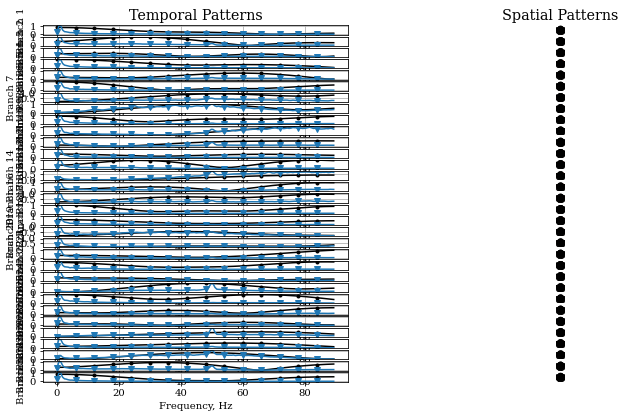

In [12]:
get_model_weights_figure(mi, epochs_list[0].info, n_branches)

In [10]:
mi = ModelInterpreter(model.feature_extractor, signal)

In [11]:
mi.unmix_signal()

Signal(data=array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), sr=600, annotations=[])

In [32]:
from torch.autograd import Variable
X_tensor = Variable(torch.FloatTensor(np.asarray(signal).T))


In [37]:
X_unmixed = model.feature_extractor.unmixing_layer(X_tensor).cpu().detach().numpy().T

In [38]:
X_unmixed

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [39]:
model.feature_extractor.unmixing_layer

Conv1d(204, 32, kernel_size=(1,), stride=(1,))

In [41]:
X_tensor.shape

torch.Size([204, 339340])

In [ ]:
y_predicted = model(X)

In [13]:
for x, y in train_iter:
    print(x)
    break

nan


/home/user/Projects/ossadtchi-ml-test-bench-speech/library/metrics.py:62: RuntimeWarning: Mean of empty slice
  correlation = float(np.nanmean(corr_multiple(y_predicted, y_true)))
